(example-quantum)=
# Quantum simulation

In this tutorial, we will learn how to use simphony's quantum simulator to simulate photonic circuits. 

## Background

Let us first discuss some foundational quantum optics that will be useful for using and understanding simphony's quantum simulator. As a warning to the reader, some of the concepts discussed here may be quite advanced but are not necessary for using simphony's quantum simulator. However, we will try to explain these concepts as simply as possible, but we encourage the interested reader to look at some of the references at the end of this tutorial for a more in-depth discussion or pick up a quantum textbook like {cite:p}`griffiths_introduction_2018` or {cite:p}`gerry_knight_2004`. 

## Quantum states

Quantum states are mathematical representations of the state of a quantum system. These quantum systems can be described using the schrodinger equation, which is a partial differential equation that describes how the quantum state of a physical system changes with time. The schrodinger equation is given by:

$$i \hbar \frac{\partial}{\partial t} |\psi(t)\rangle = \hat{H} |\psi(t)\rangle$$

where $\hbar$ is the reduced Planck constant, $\hat{H}$ is the Hamiltonian operator, and $|\psi(t)\rangle$ is the quantum state of the system at time $t$ using [bra-ket notation](https://en.wikipedia.org/wiki/Bra–ket_notation). The Hamiltonian operator can be thought of as the energy operator of the system. The solution to the schrodinger equation is the quantum state of the system at time $t$. Often times, the Hamiltonian operator is time-independent, in which case the schrodinger equation can be solved using the time evolution operator $U(t)$ as follows:

$$|\psi(t)\rangle = U(t) |\psi(0)\rangle$$

where $|\psi(0)\rangle$ is the quantum state of the system at time $t=0$. The time evolution operator is given by:

$$U(t) = e^{-\frac{i}{\hbar} \hat{H} t}$$

This leads to a simpler eigenvalue equation to solve often called the time-dependent schrodinger equation:

$$\hat{H} |\psi_n\rangle = E_n |\psi_n\rangle$$

where $|\psi_n\rangle$ is the $n$-th eigenstate of the system and $E_n$ is the $n$-th eigenvalue of the system. The eigenstates of the system are the quantum states of the system at time $t=0$ and the eigenvalues of the system are the energies of the system. The eigenstates of the system are often called the stationary states of the system because they do not change with time. The eigenstates of the system form a complete basis for the quantum state of the system at time $t=0$. This means that the quantum state of the system at time $t=0$ can be written as a linear combination of the eigenstates of the system:

$$|\psi(0)\rangle = \sum_n c_n |\psi_n\rangle$$

where $c_n$ is a complex number. The coefficients $c_n$ are called the probability amplitudes of the system. The probability amplitudes of the system are complex numbers that describe the probability of measuring the system in the $n$-th eigenstate of the system. The probability of measuring the system in the $n$-th eigenstate of the system is given by:

$$P_n = |c_n|^2$$

where $|c_n|^2$ is the squared magnitude of the probability amplitude $c_n$.

The schrodinger equation predicts that the quantum state of a system will change deterministically with time. However, when we measure the state of a quantum system, we do not observe a deterministic state but rather a probabilistic state. This is because the quantum state of a system is not directly observable. Instead, we can only measure the expectation value of an observable. The expectation value of an observable $\hat{A}$ is given by:

$$\langle \hat{A} \rangle = \langle \psi(t) | \hat{A} | \psi(t) \rangle$$

where $|\psi(t)\rangle$ is the quantum state of the system at time $t$. The expectation value of an observable is the average value of the observable over many measurements. 

## Quantum harmonic oscillator

The quantum harmonic oscillator is a quantum system that is described by the schrodinger equation. The Hamiltonian operator for the quantum harmonic oscillator is given by:

$$\hat{H} = \frac{\hat{p}^2}{2m} + \frac{1}{2} m \omega^2 \hat{x}^2$$

where $\hat{p}$ is the momentum operator, $\hat{x}$ is the position operator, $m$ is the mass of the oscillator, and $\omega$ is the angular frequency of the oscillator. The momentum and position operators are defined as follows:

$$\hat{p} = -i \hbar \frac{\partial}{\partial x}$$

$$\hat{x} = x$$

The quantum harmonic oscillator is a very important system in quantum mechanics because it is one of the few quantum systems that can be solved exactly. The quantum harmonic oscillator has a discrete energy spectrum given by:

$$E_n = \hbar \omega (n + \frac{1}{2})$$

where $n$ is a non-negative integer. The quantum harmonic oscillator has a ground state with energy $E_0 = \frac{\hbar \omega}{2}$ and an infinite number of excited states with energies $E_n = \hbar \omega (n + \frac{1}{2})$ where $n=1,2,3,...$. The quantum harmonic oscillator is also a very important system in quantum optics because it is a good approximation for the quantum state of a photon in a cavity.

## Heisenberg uncertainty principle

The [Heisenberg uncertainty principle](https://en.wikipedia.org/wiki/Uncertainty_principle) is a fundamental principle of quantum mechanics that states that it is impossible to simultaneously measure the position and momentum of a particle with arbitrary precision. This principle can be mathematically expressed as follows:

$$\Delta x \Delta p \geq \frac{\hbar}{2}$$

where $\Delta x$ is the uncertainty in the position measurement, $\Delta p$ is the uncertainty in the momentum measurement, and $\hbar$ is the reduced Planck constant. This principle can be generalized to any two observables that do not commute. 

## Gaussian states

To understand how simphony simulates quantum state evolution, let us consider a bosonic system with mode operators $\hat{a}_k$ and $\hat{a}_k^{\dagger}$ where $k=1,...,n$ that satisfy the commutation relation $[\hat{a}_k, \hat{a}_l^{\dagger}] = \delta_{kl}$. The quadrature operators $\hat{x}$ and $\hat{p}$ are defined for the $k$-th mode as follows:

$$\hat{x}_k = \frac{1}{2}(\hat{a}_k + \hat{a}_k^{\dagger})$$

$$\hat{p}_k = \frac{1}{2i}(\hat{a}_k - \hat{a}_k^{\dagger})$$

Simphony is capable of simulating a specific class of quantum states on photonic circuits, namely those whose phase space distributions can be mathematically represented in the Gaussian form. These states, called Gaussian states, are represented by a vector of means, $r$, and a covariance matrix, $\sigma$. These can be defined using the quadrature operators as follows:

$$r = \langle \hat{r} \rangle = \begin{pmatrix} \langle \hat{x}_1 \rangle \\ \langle \hat{p}_1 \rangle \\ \vdots \\ \langle \hat{x}_n \rangle \\ \langle \hat{p}_n \rangle \end{pmatrix}$$

$$\sigma_{jk} = \frac{1}{2} \langle \{ \hat{r}_j, \hat{r}_k \} \rangle - \langle \hat{r}_j \rangle \langle \hat{r}_k \rangle$$

Some examples of Gaussian states that can be fully described using this form are coherent states, squeezed states, and thermal states.

Lets look at an example of a coherent state which is the type of state that is produced by a laser. A coherent state is usually denoted by the complex field amplitude $|\alpha\rangle$ and is defined in the Fock basis (photon number basis) as:

$$|\alpha\rangle = e^{-\frac{|\alpha|^2}{2}} \sum_{n=0}^{\infty} \frac{\alpha^n}{\sqrt{n!}} |n\rangle$$

where $|n\rangle$ is the $n$-th Fock state. This state can be more simply defined in the gaussian form with a means vector of $(\Re(\alpha), \Im(\alpha))$ and a covariance matrix of $\frac{1}{4}\mathbb{I}$. In this form we can utilize a number of powerful mathematical tools to simulate the evolution of the state {cite:p}`brask2021gaussian`.

Simphony has built in common Gaussian states that can be used to initialize the quantum state of a photonic circuit. These states are defined in the :py:mod:`simphony.quantum` module. In the next cell, we will show how you can instantiate these built in Gaussian states, and then plot the Wigner function of the states, as well as an example of composing a multimode state from multiple states using the :py:func:`simphony.quantum.compose_qstate` function.

Convention: xpxp
Means: [1. 1.]
Cov: 
[[0.25 0.  ]
 [0.   0.25]]
Convention: xpxp
Means: [0 0]
Cov: 
[[0.09196986 0.        ]
 [0.         0.67957044]]
Convention: xpxp
Means: [0 0]
Cov: 
[[4.25 0.  ]
 [0.   4.25]]


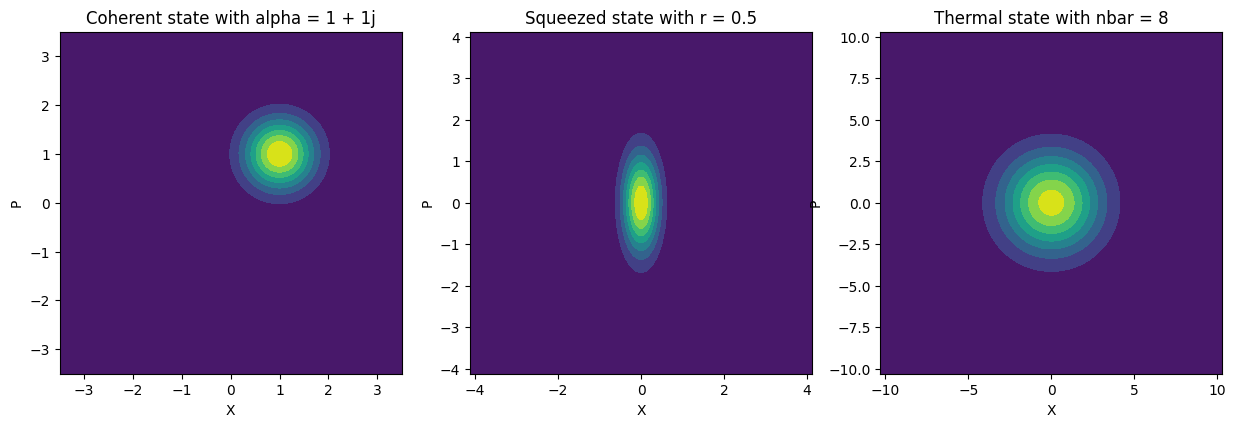

Convention: xpxp
Means: [0 0 0 0]
Cov: 
[[4.2434716 0.        3.2318034 0.       ]
 [0.        4.2434716 0.        3.2318034]
 [3.2318034 0.        4.2434716 0.       ]
 [0.        3.2318034 0.        4.2434716]]


Convention: xxpp
Means: [1. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Cov: 
[[0.25       0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.09196986 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         4.25       0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         4.2434716  3.2318034  0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         3.2318034  4.2434716  0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.25
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.67957044 0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         4.25       0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.     

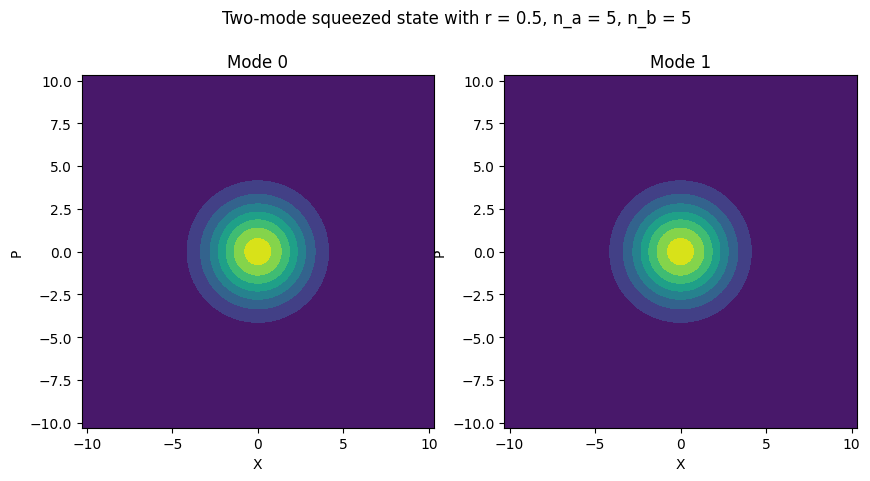

In [2]:
from simphony.quantum import CoherentState, SqueezedState, ThermalState, TwoModeSqueezedState, compose_qstate
import matplotlib.pyplot as plt

# Create a subplot with 3 columns and 1 row
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Coherent state example with alpha = 1 + 1j
coherent_state = CoherentState(port="in", alpha=1+1j) 
# port="in" is the name of the circuit port you inject the state in this case,
# we haven't defined any circuit yet, so we'll use an arbitrary port name "in"
coherent_state.plot_mode(mode=0, ax=axes[0]) # we only have one mode in this state
axes[0].set_title("Coherent state with alpha = 1 + 1j")
print(coherent_state)

# Squeezed state example with r = 0.5
squeezed_state = SqueezedState(port="in", r=0.5, phi=0, alpha=0)
squeezed_state.plot_mode(mode=0, ax=axes[1])
axes[1].set_title("Squeezed state with r = 0.5")
print(squeezed_state)

# Thermal state example with nbar = 8
thermal_state = ThermalState(port="in", nbar=8)
thermal_state.plot_mode(mode=0, ax=axes[2])
axes[2].set_title("Thermal state with nbar = 8")
print(thermal_state)
plt.show()

# Example of a two-mode squeezed state
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
two_mode_squeezed_state = TwoModeSqueezedState(r=0.5, n_a=5, n_b=5, port_a="in_a", port_b="in_b",)
two_mode_squeezed_state.plot_mode(mode=0, ax=axes[0])
two_mode_squeezed_state.plot_mode(mode=1, ax=axes[1])
axes[0].set_title("Mode 0")
axes[1].set_title("Mode 1")
plt.suptitle("Two-mode squeezed state with r = 0.5, n_a = 5, n_b = 5")
print(two_mode_squeezed_state)

multi_mode_state = compose_qstate(coherent_state, squeezed_state, thermal_state, two_mode_squeezed_state)
multi_mode_state.to_xxpp() # change the convention to xxpp
display(multi_mode_state)

You can also create an arbitrary Gaussian state by specifying the means vector and covariance matrix. In the next cell, we will show how you can create an arbitrary Gaussian state and plot the Wigner function of the state. 

```{note}

Simphony supports both 'xxpp' and 'xpxp' ordering of the quadrature operators. You can change the ordering of the quadrature operators by setting the ``convention`` parameter of the :py:class:`simphony.quantum.states.GaussianState` class to either 'xxpp' or 'xpxp'.
```

Convention: xxpp
Means: [ 1 -2 -3  4]
Cov: 
[[1.  0.5 0.3 0.2]
 [0.5 1.  0.2 0.1]
 [0.3 0.2 1.  0.5]
 [0.2 0.1 0.5 1. ]]


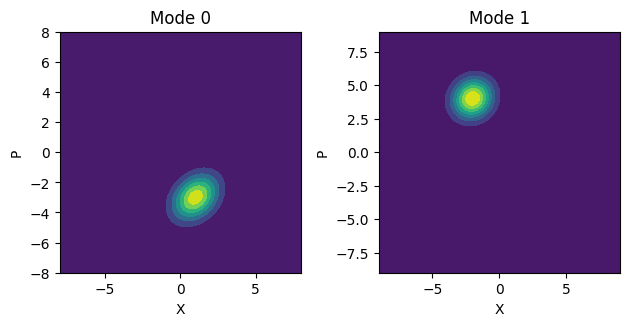

In [3]:
from simphony.quantum import QuantumState
import numpy as np

means = np.array([1,-2,-3,4])
cov = np.array([[1,0.5,0.3,0.2],[0.5,1,0.2,0.1],[0.3,0.2,1,0.5],[0.2,0.1,0.5,1]])
quantum_state = QuantumState(means, cov, ports=["in0", "in1"], convention="xxpp")

fig, axes = plt.subplots(1, 2)
quantum_state.plot_mode(mode=0, ax=axes[0])
quantum_state.plot_mode(mode=1, ax=axes[1])
axes[0].set_title("Mode 0")
axes[1].set_title("Mode 1")
plt.tight_layout()
print(quantum_state)
plt.show()


# Create a quantum state with 3 modes


```{note} 

Simphony adopts the convention of $\hbar=1/2$ such that $[\hat{x}, \hat{p}] = i\hbar = i/4$ where $\hat{x}$ is the position operator, $\hat{p}$ is the momentum operator, and $\hbar$ is the reduced Planck constant. Which corresponds to the uncertainty of the vacuum state $\langle (\Delta \hat{X})^2\rangle=\frac{1}{4}$ This convention is used in the definition of the covariance matrix and used in {cite:p}`gerry_knight_2004`.
```

## Simulation

Simphony takes the classical s-parameters of a circuit and then converts them into a quantum compatible form. One requirement of any quantum system is any transformation must be unitary. This means that it must not have any loss. Simphony converts the s-parameters into a unitary matrix by adding extra modes for vacuum states to account for the loss. Simphony assumes that any loss in a circuit is uniform across all ports. Lets start by defining a simple sax circuit for an MZI.

In [8]:
import sax

from simphony.libraries import siepic

mzi, info = sax.circuit(
    netlist={
        "instances": {
            "gc_in": "gc",
            "splitter": "ybranch",
            "long_wg": "waveguide",
            "short_wg": "waveguide",
            "combiner": "ybranch",
            "gc_out": "gc",
        },
        "connections": {
            "gc_in,o0": "splitter,port_1",
            "splitter,port_2": "long_wg,o0",
            "splitter,port_3": "short_wg,o0",
            "long_wg,o1": "combiner,port_2",
            "short_wg,o1": "combiner,port_3",
            "combiner,port_1": "gc_out,o0",
        },
        "ports": {
            "in": "gc_in,o1",
            "out": "gc_out,o1",
        },
    },
    models={
        "ybranch": siepic.y_branch,
        "waveguide": siepic.waveguide,
        "gc": siepic.grating_coupler,
    }
)

Now that we have a photonic circuit to simulate we can create our simphony simulation object. The :py:class:`simphony.quantum.QuantumSim` class requires a sax circuit, wl, and any keyword arguments needed to pass to the sax model. After creating the simulation object you need to attach a quantum state to at least one port. This is simply done by creating a :py:class:`simphony.quantum.QuantumState` object and proving the port name to which a mode will be attached. 

In [9]:
from simphony.quantum import QuantumSim, CoherentState

wl = 1.55 # um
sim = QuantumSim(ckt=mzi, wl=wl, long_wg={"length": 150.0}, short_wg={"length": 50.0})
qstate = CoherentState(port="in", alpha=1+1j)
sim.add_qstate(qstate=qstate)
res = sim.run()

After the run function returns a :py:class:`simphony.quantum.QuantumResult` object, which contains the s-parameters of the circuit, the input state, the output state, as well as the circuit unitary transformation. The resulting states will always have $2N$ modes where $N$ is the number of ports in the circuit. The first $N$ modes are the modes associated with the ports of the circuit in the order of the sax port keys.  The last $N$ modes are the loss channel modes that are added to make the circuit unitary and usually can be ignored.

QuantumResult(s_params=Array([[[0.09968509-0.02082751j, 0.38472682+0.16065454j],
        [0.38472682+0.16065452j, 0.09968508-0.02082751j]]],      dtype=complex64), input_means=Array([1., 0., 0., 0., 1., 0., 0., 0.], dtype=float32), input_cov=Array([[0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.25, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.25, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.25, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.25]], dtype=float32), transforms=Array([[[ 9.9685088e-02,  3.8472682e-01, -9.0321898e-01,  0.0000000e+00,
          2.0827513e-02, -1.6065454e-01,  3.9880371e-10, -0.0000000e+00],
        [ 3.8472682e-01,  9.9685080e-02,  0.0000000e+00, -9.0321898e-01,
         -1.6065452e-01,  2.0827508e-02, -0.0000000e+0

array([<Axes: title={'center': 'Mode [0]'}, xlabel='X', ylabel='P'>,
       <Axes: title={'center': 'Mode [1]'}, xlabel='X', ylabel='P'>,
       <Axes: title={'center': 'Mode [2]'}, xlabel='X', ylabel='P'>,
       <Axes: title={'center': 'Mode [3]'}, xlabel='X', ylabel='P'>],
      dtype=object)

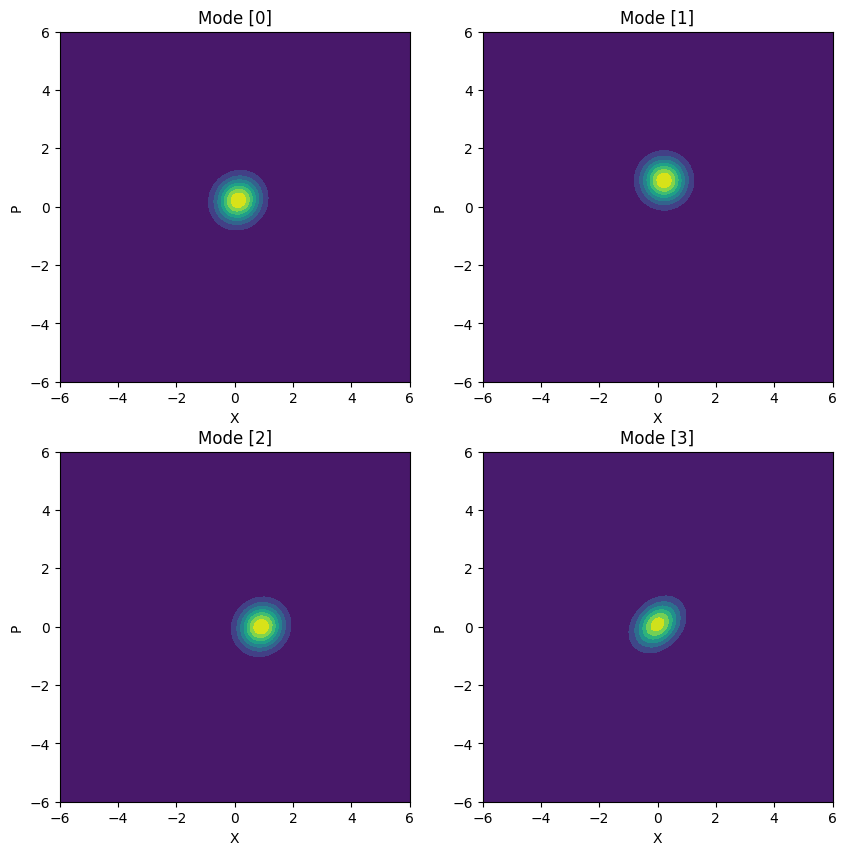

In [10]:
from simphony.quantum import plot_quantum_result

print(res)

plot_quantum_result(res, wl_ind=0, include_loss_modes=True)

A useful exercise after simulating is to calculate the probabilities of detecting a specific number of photons on a photon number resolving (PNR) detector. This can be done by converting the output state into the Fock basis. In the following cell we will show how to do this using [thewalrus](https://the-walrus.readthedocs.io/en/fix_numba_decorator/index.html) package. A caveat of this method is that the Gaussian state must be a pure state according to this definition: 

$$\mu = \frac{1}{\det(2 \sigma_{xp} / \hbar)} = 1$$

where $\mu$ is the purity of the state, $\sigma_{xp}$ is the covariance matrix of the state, and $\hbar$ is the reduced Planck constant where simphony uses the convention of $\hbar=1/2$. This is not a problem for coherent and squeezed states, but thermal states do not meet this requirement.

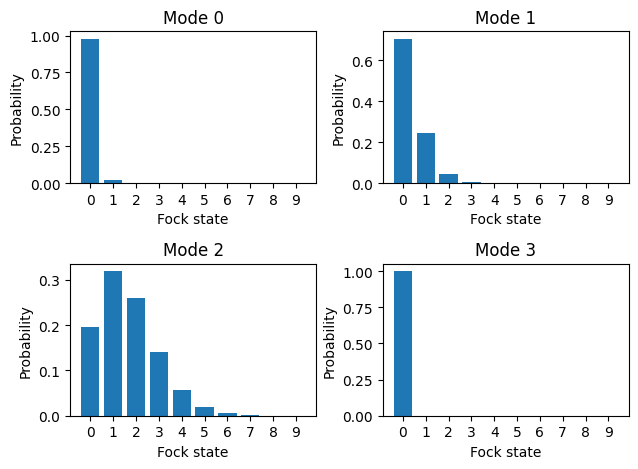

In [12]:
import thewalrus as tw

wl = 1.55 # um
sim = QuantumSim(ckt=mzi, wl=wl, long_wg={"length": 150.0}, short_wg={"length": 50.0})
qstate = CoherentState(port="in", alpha=1+1j)
sim.add_qstate(qstate=qstate)
res = sim.run()
res_state = res.state()

fig, axes = plt.subplots(2,2)
axes = axes.flatten()
for i in range(res_state.N):
    means, cov = res_state.modes(i)
    fock_amp = tw.quantum.state_vector(means, cov, cutoff=10, hbar=1/2, check_purity=True)
    ax = axes[i]
    ax.set_title(f'Mode {i}')
    ax.bar(range(len(fock_amp)), abs(fock_amp)**2)
    ax.set_xticks(range(len(fock_amp)), range(len(fock_amp)))
    ax.set_xlabel("Fock state")
    ax.set_ylabel("Probability")
plt.tight_layout()
plt.show()

**References**

```{bibliography}
:filter: docname in docnames
:style: unsrt
```